### Master N-body Integrator

Includes both the vertlet integrator function, as well as the 4th Order Hermite method. 

Created 17/11/2021

In [1]:
''' Common constants and imports '''

# Importing external libraries
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Setting up constants
G = np.array([6.67e-11], dtype=np.float64)
softening = np.array([6e8], dtype=np.float64)
eta = 0.1
dt = np.int64(60*60*12)

In [21]:
''' Functions and prerequisites for the Vertlet method '''

# The main class describing bodies in the simulation
class object():

    # Initial setup upon calling an instance of the class
    def __init__(self, position, velocity, mass):

        # Setting the objects local variables
        self.mass = mass

        self.position = np.array([position[0], position[1], position[2]], dtype=np.float64)
        self.velocity = np.array([velocity[0], velocity[1], velocity[2]], dtype=np.float64)
        self.acceleration = np.array([0,0,0], dtype=np.float64)
        self.adot = np.array([0,0,0], dtype=np.float64)
        self.a2dot = np.array([0,0,0], dtype=np.float64)
        self.a3dot = np.array([0,0,0], dtype=np.float64)

        # Arrays for plotting ONLY # TODO: Remove after testing 
        self.xarr = []
        self.yarr = []
        self.zarr = []

        self.kineticEnergy = []
        self.gravitationalPE = []
        self.GPE = 0

# Function to determine gravitational forces 
def gravitate(body, otherBody):

    # Calculating the accelerations and GPE
    body.acceleration =+ -G * otherBody.mass * (body.position-otherBody.position) / (np.linalg.norm(body.position-otherBody.position)**3 + softening**3)
    body.GPE =+ -G * body.mass * otherBody.mass / np.linalg.norm(body.position-otherBody.position)

# Function to update velocity vertlet positions 
def velocityVertletPosition(body):

    # Updating positions
    body.position = body.position + body.velocity * dt + 0.5 * body.acceleration * dt * dt

    # Adding to the position arrays # TODO: Remove after testing
    body.xarr.append(body.position[0])
    body.yarr.append(body.position[1])
    body.zarr.append(body.position[2])

# Function to update velocities and run the gravity function
def velocityVertletVelocity(bodiesList, body):

    # Getting a list of the bodies to gravitate to
    bodiesIndex = np.arange(0, len(bodiesList), 1, np.int64)
    bodiesIndex = np.delete(bodiesIndex, bodiesList.index(body))

    # Storing the values of acceleration before they are updated
    oldAcceleration = body.acceleration

    # Updating the acceleration for the new position of the body
    body.GPE = 0

    for i in bodiesIndex:
        gravitate(body, bodiesList[i])

    body.gravitationalPE.append(body.GPE)

    # Updating the velocity 
    body.velocity = body.velocity + 0.5 * (body.acceleration + oldAcceleration) * dt

    # Storing the change in acceleration
    body.adot = body.acceleration - oldAcceleration

    # Calculating the KE
    body.kineticEnergy.append(0.5*body.mass*np.linalg.norm(body.velocity)**2)

# Function to determine the timestep and monitor the accelerations 
def timeStepCommander(bodiesList):
    # Creating the list of accelerations
    accMags = []

    # Getting the magnitudes of all bodies accelerations
    for body in bodiesList:
        accMags.append(np.sqrt(body.acceleration[0]**2 + body.acceleration[1]**2 + body.acceleration[2]**2))

    # Finding the maximum of these
    maximumAcceleration = max(accMags)

    # Returning the timestep to use
    return np.sqrt(2*eta*softening/np.abs(maximumAcceleration))


    # Creating list of accelerations and adots 
    accMags = []
    adots = []

    # Getting the magnitudes of all bodies accelerations and adots
    for body in bodiesList:
        accMags.append(np.linalg.norm(body.acceleration))
        adots.append(np.linalg.norm(body.adot))

    # Finding the minimum
    accelerationOverAdot = np.divide(accMags, adots)

    # Returning the timestep to use
    return min(accelerationOverAdot)

In [3]:
''' Function to run the vertlet method '''

def vertletIntegrator(dt, dynamicTimeStep, dataFile):

    # Importing the initial conditions from a text file
    timeKeeper, maxTime, xpos, ypos, zpos, xvel, yvel, zvel, mass = np.loadtxt(dataFile, delimiter=" ", skiprows=1, unpack=True, dtype=np.float64)

    # Turning the imported data into arrays used by functions
    IPs = np.zeros((len(xpos),3), dtype=np.float64)
    IVs = np.zeros((len(xpos),3), dtype=np.float64)
    MSs = np.zeros(len(xpos), dtype=np.float64)

    # Turning the arrays of x, y and z etc into arrays the object class can use
    for i in range(len(xpos)):
        IPs[i] = [xpos[i], ypos[i], zpos[i]]
        IVs[i] = [xvel[i], yvel[i], zvel[i]]
        MSs[i] = mass[i]

    # Changing the timeKeeper and maxTime variables from lists to numbers
    timeKeeper = timeKeeper[0]
    maxTime = maxTime[0]

    # Initialising the system, getting the bodies list
    bodiesList = []
    for i in range(len(IPs)):
        bodiesList.append(object(IPs[i], IVs[i], MSs[i]))

    # Calculate the initial accelerations
    for body in bodiesList:
        # Getting a list of the bodies to gravitate to
        bodiesIndex = np.arange(0, len(bodiesList), 1, np.int64)
        bodiesIndex = np.delete(bodiesIndex, bodiesList.index(body))

        # Looping
        for i in bodiesIndex:
            gravitate(body, bodiesList[i])

    # The main program loop
    while timeKeeper < maxTime:
        
        # Updating positions of all objects
        for body in bodiesList:
            velocityVertletPosition(body)

        # Updating the velocities of all objects, and gravitating
        for body in bodiesList:
            velocityVertletVelocity(bodiesList, body)

        # Ticking the timekeeper
        timeKeeper = timeKeeper + dt

        # Determining what the next time step should be
        if dynamicTimeStep == True:
            dt = timeStepCommander(bodiesList)

    return bodiesList

In [24]:
''' Functions for running the 4th Order Hermite Integrator '''

@jit(nopython=True)
def initialAccelerations(xpos, ypos, zpos, xvel, yvel, zvel, mass, numberOfBodies):
    # Resetting all acceleration values back to zero
    xacel0 = np.zeros(numberOfBodies, dtype=np.float64)
    yacel0 = np.zeros(numberOfBodies, dtype=np.float64)
    zacel0 = np.zeros(numberOfBodies, dtype=np.float64)

    xadot0 = np.zeros(numberOfBodies, dtype=np.float64)
    yadot0 = np.zeros(numberOfBodies, dtype=np.float64)
    zadot0 = np.zeros(numberOfBodies, dtype=np.float64)

    # Looping through each body in the simulation
    for bodyIndex in range(numberOfBodies):

        # Getting a list of bodies to gravitate to for this body
        bodyIndexes = np.arange(0, numberOfBodies, 1, np.int64)
        bodyIndexes = np.delete(bodyIndexes,bodyIndex)

        # Determining the gravitational force felt by this body from every other body
        for otherBodyIndex in bodyIndexes:

            # Calculating the position and velocity vector components and magnitude
            rijx = xpos[bodyIndex] - xpos[otherBodyIndex]
            rijy = ypos[bodyIndex] - ypos[otherBodyIndex]
            rijz = zpos[bodyIndex] - zpos[otherBodyIndex]
            rij = np.sqrt(rijx*rijx + rijy*rijy + rijz*rijz)

            vijx = xvel[bodyIndex] - xvel[otherBodyIndex]
            vijy = yvel[bodyIndex] - yvel[otherBodyIndex]
            vijz = zvel[bodyIndex] - zvel[otherBodyIndex]
            vij = np.sqrt(vijx*vijx + vijy*vijy + vijz*vijz)

            # Determining dot product of the velocity and position vectors
            rijvijdot = rijx*vijx + rijy*vijy + rijz*vijz

            # Calculating the commom denominator
            divisonTerm = rij*rij + softening[0]*softening[0]
            divisonTermThreeTwo = divisonTerm**(3/2)
            divisonTermFiveTwo = divisonTerm**(5/2)

            # Calculating the acceleration and first derivative of acceleration
            xacel0[bodyIndex] = xacel0[bodyIndex] + (-G[0] * mass[otherBodyIndex]) * (rijx/divisonTermThreeTwo)
            yacel0[bodyIndex] = yacel0[bodyIndex] + (-G[0] * mass[otherBodyIndex]) * (rijy/divisonTermThreeTwo)
            zacel0[bodyIndex] = zacel0[bodyIndex] + (-G[0] * mass[otherBodyIndex]) * (rijz/divisonTermThreeTwo)

            xadot0[bodyIndex] = xadot0[bodyIndex] + (G[0] * mass[otherBodyIndex]) * ((vijx/divisonTermThreeTwo) + 3*(rijvijdot*rijx/divisonTermFiveTwo))
            yadot0[bodyIndex] = yadot0[bodyIndex] + (G[0] * mass[otherBodyIndex]) * ((vijy/divisonTermThreeTwo) + 3*(rijvijdot*rijy/divisonTermFiveTwo))
            zadot0[bodyIndex] = zadot0[bodyIndex] + (G[0] * mass[otherBodyIndex]) * ((vijz/divisonTermThreeTwo) + 3*(rijvijdot*rijz/divisonTermFiveTwo))

    return xacel0, yacel0, zacel0, xadot0, yadot0, zadot0

@jit(nopython=True)
def predictedAccelerations(xpos, ypos, zpos, xvel, yvel, zvel, mass, numberOfBodies):
    # Resetting all acceleration values back to zero
    xacel = np.zeros(numberOfBodies, dtype=np.float64)
    yacel = np.zeros(numberOfBodies, dtype=np.float64)
    zacel = np.zeros(numberOfBodies, dtype=np.float64)

    xadot = np.zeros(numberOfBodies, dtype=np.float64)
    yadot = np.zeros(numberOfBodies, dtype=np.float64)
    zadot = np.zeros(numberOfBodies, dtype=np.float64)

    # Looping through each body in the simulation
    for bodyIndex in range(numberOfBodies):

        # Getting a list of bodies to gravitate to for this body
        bodyIndexes = np.arange(0, numberOfBodies, 1, np.int64)
        bodyIndexes = np.delete(bodyIndexes,bodyIndex)

        # Determining the gravitational force felt by this body from every other body
        for otherBodyIndex in bodyIndexes:

            # Calculating the position and velocity vector components and magnitude
            rijx = xpos[bodyIndex] - xpos[otherBodyIndex]
            rijy = ypos[bodyIndex] - ypos[otherBodyIndex]
            rijz = zpos[bodyIndex] - zpos[otherBodyIndex]
            rij = np.sqrt(rijx*rijx + rijy*rijy + rijz*rijz)

            vijx = xvel[bodyIndex] - xvel[otherBodyIndex]
            vijy = yvel[bodyIndex] - yvel[otherBodyIndex]
            vijz = zvel[bodyIndex] - zvel[otherBodyIndex]
            vij = np.sqrt(vijx*vijx + vijy*vijy + vijz*vijz)

            # Determining dot product of the velocity and position vectors
            rijvijdot = rijx*vijx + rijy*vijy + rijz*vijz

            # Calculating the commom denominator
            divisonTerm = rij*rij + softening[0]*softening[0]
            divisonTermThreeTwo = divisonTerm**(3/2)
            divisonTermFiveTwo = divisonTerm**(5/2)

            # Calculating the acceleration and first derivative of acceleration
            xacel[bodyIndex] = xacel[bodyIndex] + (-G[0] * mass[otherBodyIndex]) * (rijx/divisonTermThreeTwo)
            yacel[bodyIndex] = yacel[bodyIndex] + (-G[0] * mass[otherBodyIndex]) * (rijy/divisonTermThreeTwo)
            zacel[bodyIndex] = zacel[bodyIndex] + (-G[0] * mass[otherBodyIndex]) * (rijz/divisonTermThreeTwo)

            xadot[bodyIndex] = xadot[bodyIndex] + (G[0] * mass[otherBodyIndex]) * ((vijx/divisonTermThreeTwo) + 3*(rijvijdot*rijx/divisonTermFiveTwo))
            yadot[bodyIndex] = yadot[bodyIndex] + (G[0] * mass[otherBodyIndex]) * ((vijy/divisonTermThreeTwo) + 3*(rijvijdot*rijy/divisonTermFiveTwo))
            zadot[bodyIndex] = zadot[bodyIndex] + (G[0] * mass[otherBodyIndex]) * ((vijz/divisonTermThreeTwo) + 3*(rijvijdot*rijz/divisonTermFiveTwo))

    return xacel, yacel, zacel, xadot, yadot, zadot

@jit(nopython=True)
def hermiteTimeStep(xacel, yacel, zacel, xadot, yadot, zadot, xa2dot, ya2dot, za2dot, xa3dot, ya3dot, za3dot, numberOfBodies):

    # Creating an empty list for the prospective timesteps
    dtList = []

    # Looping through each body to determine the timestep for that body
    for body in range(numberOfBodies):

        # Calculating the scalar for a, adot, a2dot and a3dot
        a = np.sqrt(xacel[body]*xacel[body] + yacel[body]*yacel[body] + zacel[body]*zacel[body])
        ad = np.sqrt(xadot[body]*xadot[body] + yadot[body]*yadot[body] + zadot[body]*zadot[body])
        add = np.sqrt(xa2dot[body]*xa2dot[body] + ya2dot[body]*ya2dot[body] + za2dot[body]*za2dot[body])
        addd = np.sqrt(xa3dot[body]*xa3dot[body] + ya3dot[body]*ya3dot[body] + za3dot[body]*za3dot[body])

        # Calculating the timestep
        dtList.append(np.sqrt(eta * ((a*add + ad**2)/(ad*addd + add**2))))

    # Returning the smallest timestep for usage
    return min(dtList)

@jit(nopython=True)
def gravitationalPotential(xpos, ypos, zpos, mass, numberOfBodies):
    # Resetting values to 0
    gravitationalPotentials = np.zeros(numberOfBodies, dtype=np.float64)

    for bodyIndex in range(numberOfBodies):

        # Getting a list of bodies to gravitate to for this body
        bodyIndexes = np.arange(0, numberOfBodies, 1, np.int64)
        bodyIndexes = np.delete(bodyIndexes,bodyIndex)

        gravitationalPotential = 0

        for otherBodyIndex in bodyIndexes:
            # Calculating the position and velocity vector components and magnitude
            rijx = xpos[bodyIndex] - xpos[otherBodyIndex]
            rijy = ypos[bodyIndex] - ypos[otherBodyIndex]
            rijz = zpos[bodyIndex] - zpos[otherBodyIndex]
            rij = np.sqrt(rijx*rijx + rijy*rijy + rijz*rijz)

            # Updating gravitational potential
            gravitationalPotential = np.float64(gravitationalPotential - (G[0]*mass[bodyIndex]*mass[otherBodyIndex])/rij)

        gravitationalPotentials[bodyIndex] = gravitationalPotential

    return gravitationalPotentials

# Function to start the integrator
def initIntegrator(dataFile):
    # Importing initial conditions
    timeKeeper, maxTime, xpos, ypos, zpos, xvel, yvel, zvel, mass = np.loadtxt(dataFile, delimiter=" ", skiprows=1, unpack=True, dtype=np.float64)

    # Getting the number of bodies
    numberOfBodies = len(xpos)

    # Setting up arrays
    xacel = np.zeros(numberOfBodies, dtype=np.float64)
    yacel = np.zeros(numberOfBodies, dtype=np.float64)
    zacel = np.zeros(numberOfBodies, dtype=np.float64)

    xadot = np.zeros(numberOfBodies, dtype=np.float64)
    yadot = np.zeros(numberOfBodies, dtype=np.float64)
    zadot = np.zeros(numberOfBodies, dtype=np.float64)

    xa2dot = np.zeros(numberOfBodies, dtype=np.float64)
    ya2dot = np.zeros(numberOfBodies, dtype=np.float64)
    za2dot = np.zeros(numberOfBodies, dtype=np.float64)

    xa3dot = np.zeros(numberOfBodies, dtype=np.float64)
    ya3dot = np.zeros(numberOfBodies, dtype=np.float64)
    za3dot = np.zeros(numberOfBodies, dtype=np.float64)

    # Arrays for plotting
    xarrs = np.zeros((numberOfBodies,1), dtype=np.float64)
    yarrs = np.zeros((numberOfBodies,1), dtype=np.float64)
    zarrs = np.zeros((numberOfBodies,1), dtype=np.float64)

    # Setting up the values for time etc
    timeKeeper = timeKeeper[0]
    maxTime = maxTime[0]

    # Setting up arrays to determine the kinetic and gravitational potential energy
    KE = np.zeros((numberOfBodies,1), dtype=np.float64)
    GP = np.zeros((numberOfBodies,1), dtype=np.float64)

    return timeKeeper, maxTime, xpos, ypos, zpos, xvel, yvel, zvel, mass, xacel, yacel, zacel, xadot, yadot, zadot, xa2dot, ya2dot, za3dot, xa3dot, ya3dot, za3dot, numberOfBodies, xarrs, yarrs, zarrs, KE, GP

In [38]:
''' Function to run the 4th Order Hermite Method '''

def hermiteIntegrator(dt, dynamicTimeStep, outputInterval, dataFile):
    timeKeeper, maxTime, xpos, ypos, zpos, xvel, yvel, zvel, mass, xacel, yacel, zacel, xadot, yadot, zadot, xa2dot, ya2dot, za3dot, xa3dot, ya3dot, za3dot, numberOfBodies, xarrs, yarrs, zarrs, KE, GP = initIntegrator(dataFile)
    timeElapsedSinceLastOutput = 0

    while timeKeeper < maxTime:

        # Setting up constants to save computation time
        dt2 = (dt**2)
        dt3 = (dt**3)
        dt4 = (dt**4)
        dt5 = (dt**5)
        half = np.float64(1./2.)
        sixth = np.float64(1./6.)
        twentyFourth = np.float64(1./24.)
        oneHundredAndTwentyth = np.float64(1./120.)

        # Determining the first accelerations
        xacel0, yacel0, zacel0, xadot0, yadot0, zadot0 = initialAccelerations(xpos, ypos, zpos, xvel, yvel, zvel, mass, numberOfBodies)

        # Predicting the objects positions and velocities based on these accelerations
        xpos = np.float64(dt3*sixth*xadot0 + dt2*half*xacel0 + dt*xvel + xpos)
        ypos = np.float64(dt3*sixth*yadot0 + dt2*half*yacel0 + dt*yvel + ypos)
        zpos = np.float64(dt3*sixth*zadot0 + dt2*half*zacel0 + dt*zvel + zpos)

        xvel = np.float64(dt2*half*xadot0 + dt*xacel0 + xvel)
        yvel = np.float64(dt2*half*yadot0 + dt*yacel0 + yvel)
        zvel = np.float64(dt2*half*zadot0 + dt*zacel0 + zvel)

        # Using these predictions to determine the accelerations again
        xacel, yacel, zacel, xadot, yadot, zadot = predictedAccelerations(xpos, ypos, zpos, xvel, yvel, zvel, mass, numberOfBodies)

        # Using these values to determine second and third derivative of acceleration
        xa2dot = np.float64(-6*(xacel0 - xacel)/dt2 - (4*xadot0 + 2*xadot)/dt)
        ya2dot = np.float64(-6*(yacel0 - yacel)/dt2 - (4*yadot0 + 2*yadot)/dt)
        za2dot = np.float64(-6*(zacel0 - zacel)/dt2 - (4*zadot0 + 2*zadot)/dt)

        xa3dot = np.float64(12*(xacel0 - xacel)/dt3 + 6*(xadot0 + xadot)/dt2)
        ya3dot = np.float64(12*(yacel0 - yacel)/dt3 + 6*(yadot0 + yadot)/dt2)
        za3dot = np.float64(12*(zacel0 - zacel)/dt3 + 6*(zadot0 + zadot)/dt2)

        # Using the derivaties to correct the position and velocity values
        xpos = np.float64(xpos + (xa2dot*twentyFourth*dt4) + (xa3dot*oneHundredAndTwentyth*dt5))
        ypos = np.float64(ypos + (ya2dot*twentyFourth*dt4) + (ya3dot*oneHundredAndTwentyth*dt5))
        zpos = np.float64(zpos + (za2dot*twentyFourth*dt4) + (za3dot*oneHundredAndTwentyth*dt5))

        xvel = np.float64(xvel + (xa2dot*sixth*dt3) + (xa3dot*twentyFourth*dt4))
        yvel = np.float64(yvel + (ya2dot*sixth*dt3) + (ya3dot*twentyFourth*dt4))
        zvel = np.float64(zvel + (za2dot*sixth*dt3) + (za3dot*twentyFourth*dt4))

        # Calculating the KE and GPE
        kineticEnergy = half * mass * (xvel*xvel + yvel*yvel + zvel*zvel)
        KE = np.append(KE, np.array_split(kineticEnergy,numberOfBodies), axis=1)

        gravitationalPotentials = gravitationalPotential(xpos, ypos, zpos, mass, numberOfBodies)
        GP = np.append(GP, np.array_split(gravitationalPotentials, numberOfBodies), axis=1)

        # Updating the timestep based on the accelerations felt
        if dynamicTimeStep == True:
            dt = hermiteTimeStep(xacel, yacel, zacel, xadot, yadot, zadot, xa2dot, ya2dot, za2dot, xa3dot, ya3dot, za3dot, numberOfBodies)

        # Ticking the clock
        timeKeeper = timeKeeper + dt

        # Outputting based on the given time interval
        timeElapsedSinceLastOutput = timeElapsedSinceLastOutput + dt
        if timeElapsedSinceLastOutput > outputInterval:
            timeElapsedSinceLastOutput = 0

            xarrs = np.append(xarrs, np.array_split(xpos, numberOfBodies), axis=1)
            yarrs = np.append(yarrs, np.array_split(ypos, numberOfBodies), axis=1)
            zarrs = np.append(zarrs, np.array_split(zpos, numberOfBodies), axis=1)

            # TODO: output to a file

    return GP, KE, xarrs, yarrs, zarrs

17/11/2021 - Running a test of the Earth-Sun system using both integrators to compare their relative accuracies

Text(0, 0.5, 'y, m')

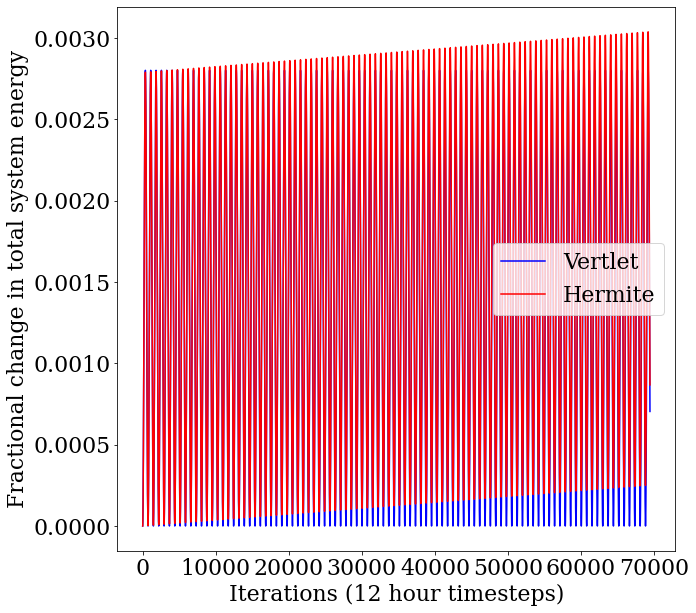

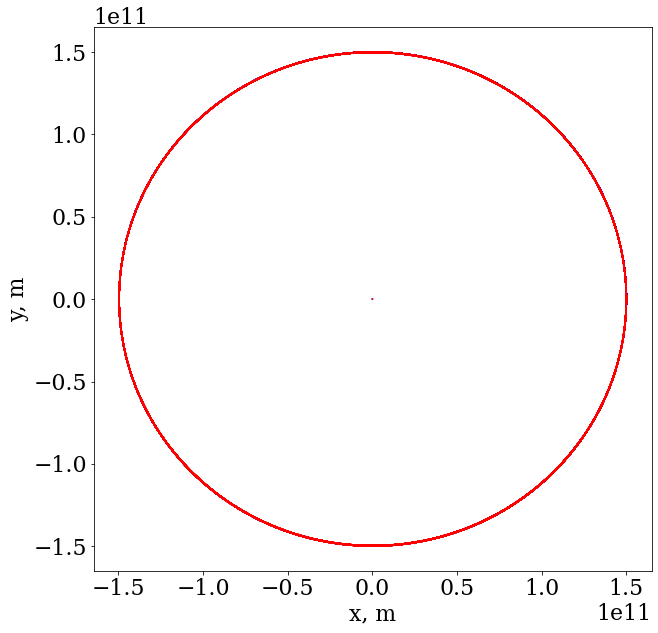

In [39]:
# Setting the datafile string
textFile = "earthSunData.txt"

# Setting the desired dt
dt=np.int64(60*60*12)

# Running vertlet for this system
objectList = vertletIntegrator(dt, False, textFile)

# Running hermite for this system
k, g, x, y, z = hermiteIntegrator(dt, False, 10, textFile)

# Getting the initial total energy of the Earth
initEnergyE = k[1][1] - g[1][1]
initEnergyS = k[0][1] - g[0][1]

# Calculating the change of the energy with time for each method
vertletKEE = objectList[1].kineticEnergy
vertletGPEE = objectList[1].gravitationalPE
vertletKES = objectList[0].kineticEnergy
vertletGPES = objectList[0].gravitationalPE

EE = [-x + y for x, y in zip(vertletKEE, vertletGPEE)]
ES = [-x + y for x, y in zip(vertletKES, vertletGPES)]

vertletEnergyEvolution = ([x+y for x, y in zip(EE, ES)] - initEnergyE -initEnergyS) / (initEnergyE + initEnergyS)
hermiteEnergyEvolution = ((k[1][1:] - g[1][1:] + k[0][1:] - g[0][1:]) - initEnergyE - initEnergyS) / (initEnergyE  + initEnergyS)

# Plotting this evolution
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family':'serif'})
plt.plot(vertletEnergyEvolution, "b", label="Vertlet")
plt.plot(hermiteEnergyEvolution, "r", label="Hermite")
plt.xlabel("Iterations (12 hour timesteps)")
plt.ylabel("Fractional change in total system energy")
plt.legend(loc="best")

# Plotting the positions 
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family':'serif'})
plt.plot(objectList[0].xarr, objectList[0].yarr, "b")
plt.plot(objectList[1].xarr, objectList[1].yarr, "b")
plt.plot(x[0][1:], y[0][1:], "r")
plt.plot(x[1][1:], y[1][1:], "r")
plt.xlabel("x, m")
plt.ylabel("y, m")

24/11/2021 - Testing Hermite vs Vertlet for an unstable system (Eccentric Earth)

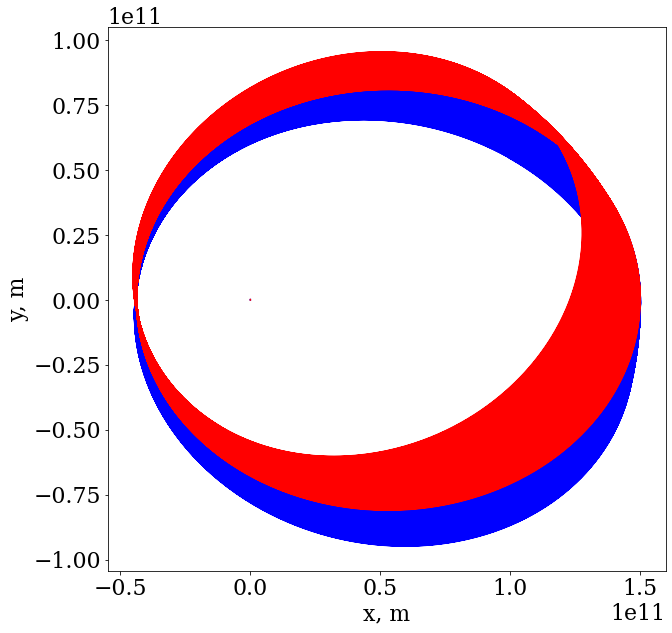

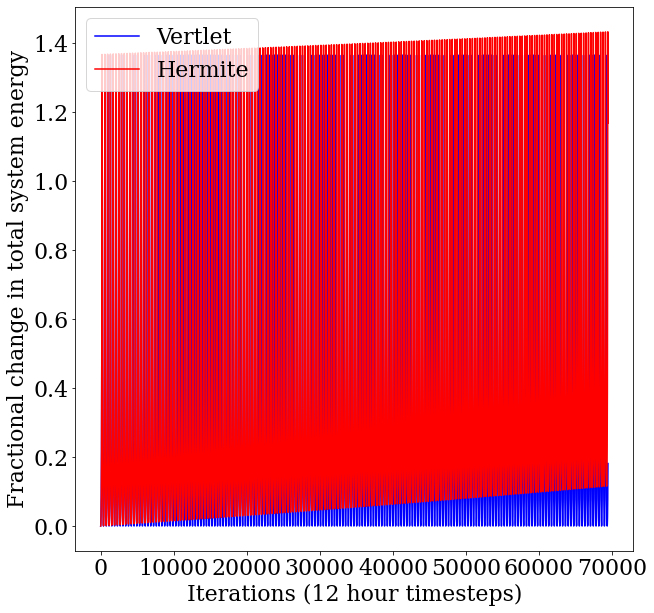

In [36]:
# Setting the datafile string
textFile = "earthSunDataEccentric.txt"

# Setting the desired dt
dt=np.int64(60*60*12)

# Running vertlet for this system
objectList = vertletIntegrator(dt, False, textFile)

# Running hermite for this system
g, k, x, y, z = hermiteIntegrator(dt, False, 10, textFile)

# Getting the initial total energy of the Earth
initEnergyE = k[1][1] + g[1][1]
initEnergyS = k[0][1] + g[0][1]

# Calculating the change of the energy with time for each method
vertletKEE = objectList[1].kineticEnergy
vertletGPEE = objectList[1].gravitationalPE
vertletKES = objectList[0].kineticEnergy
vertletGPES = objectList[0].gravitationalPE

EE = [x + y for x, y in zip(vertletKEE, vertletGPEE)]
ES = [x + y for x, y in zip(vertletKES, vertletGPES)]

vertletEnergyEvolution =  ([x+y for x, y in zip(EE, ES)] - initEnergyE - initEnergyS) / (initEnergyE + initEnergyS)
hermiteEnergyEvolution = ((k[1][1:] + g[1][1:] + k[0][1:] + g[0][1:]) - initEnergyE - initEnergyS) / (initEnergyE  + initEnergyS)

# Plotting this evolution
plt.figure(figsize=(10,10))
plt.plot(objectList[0].xarr, objectList[0].yarr, "b")
plt.plot(objectList[1].xarr, objectList[1].yarr, "b")
plt.plot(x[0][1:], y[0][1:], "r")
plt.plot(x[1][1:], y[1][1:], "r")
plt.xlabel("x, m")
plt.ylabel("y, m")

plt.figure(figsize=(10,10))
plt.plot(vertletEnergyEvolution, "b", label="Vertlet")
plt.plot(hermiteEnergyEvolution, "r", label="Hermite")
plt.xlabel("Iterations (12 hour timesteps)")
plt.ylabel("Fractional change in total system energy")
plt.legend(loc="best")

18/11/2021 - Testing the code for a single cluster, and added a subroutine to output the simulation data per a specified timeframe

Text(0.5, 0, 'z, m')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
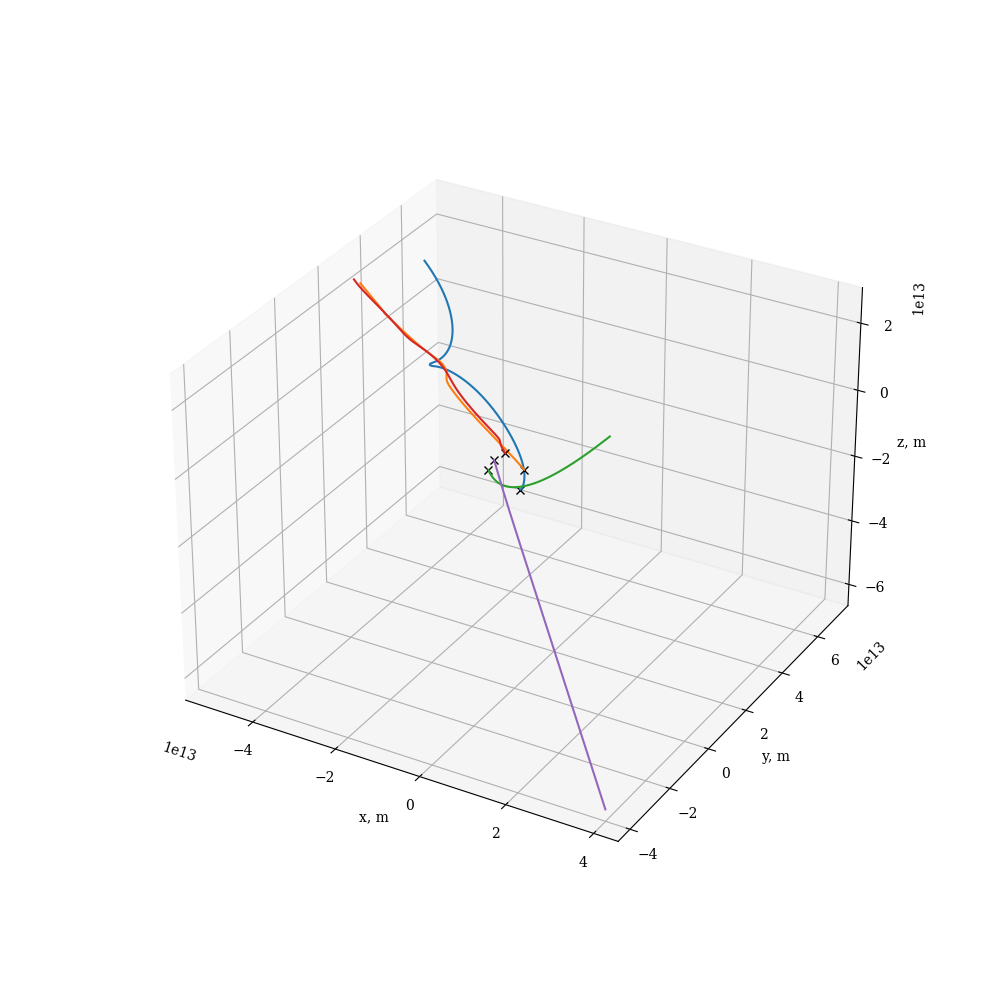

In [40]:
''' Running cluster test simulations '''

# Setting the datafile string
textFile = "simData.txt"

# Running the hermite integrator for this file
g, k, x, y, z = hermiteIntegrator(1, True, 60*60*365*24, textFile)

%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
for i in range(len(x)):
    plt.plot(x[i][1], y[i][1], z[i][1], "kx" )
    plt.plot(x[i][1:], y[i][1:], z[i][1:], markersize=1)

plt.xlabel("x, m")
plt.ylabel("y, m")
ax.set_zlabel("z, m")



07/12/2021 - Testing how vertlet handles more than two bodies



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
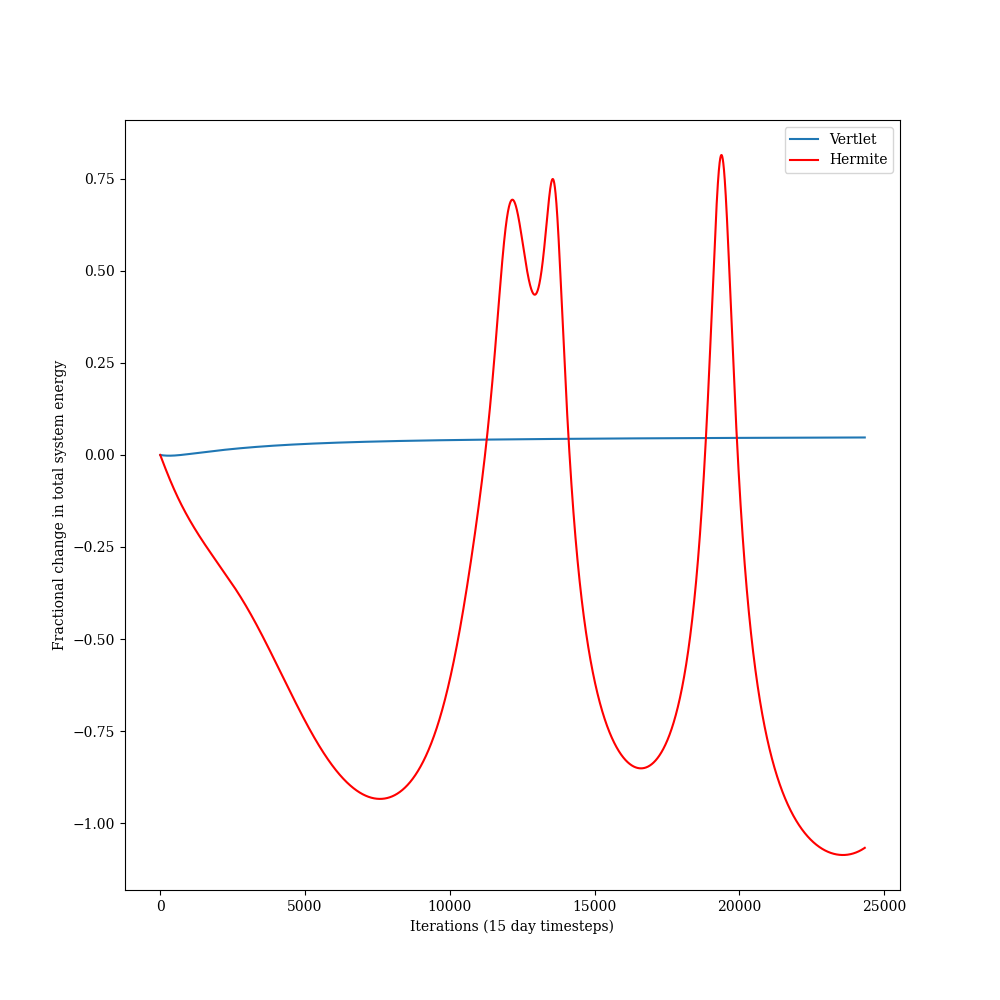

In [44]:
# Setting the datafile string
textFile = "simData.txt"

# Setting the timestep
dt = np.int64(15*60*60*24)

# Running vertlet for this simulation
clusterObjectList = vertletIntegrator(dt, False, textFile)

# Running the hermite integrator for this file
g, k, x, y, z = hermiteIntegrator(dt, False, 60*60*365*24, textFile)

# Getting the energies for Vertlet
vEnergy = np.zeros(len(clusterObjectList[0].kineticEnergy))

for i in range(len(clusterObjectList)):
    KE = clusterObjectList[i].kineticEnergy
    GP = clusterObjectList[i].gravitationalPE
    TE = np.zeros(len(KE))

    for j in range(len(KE)):
        TE[j] = KE[j] + GP[j]

    vEnergy = vEnergy + TE

vEnergy = (vEnergy - vEnergy[0]) / vEnergy[0]

TE1 = k[0] + g[0]

TE2 = k[1] + g[1]

TE3 = k[2] + g[2]

TE4 = k[3] + g[3]

TE5 = k[4] + g[4]

TE = TE1 + TE2 + TE3 + TE4 + TE5
TE = (TE-TE[1])/TE[1]

plt.figure(figsize=(10,10))
plt.plot(vEnergy, label="Vertlet")
plt.plot(TE[1:], "r", label="Hermite")
plt.xlabel("Iterations (15 day timesteps)")
plt.ylabel("Fractional change in total system energy")
plt.legend(loc="best")

Text(0.5, 0, 'z, m')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
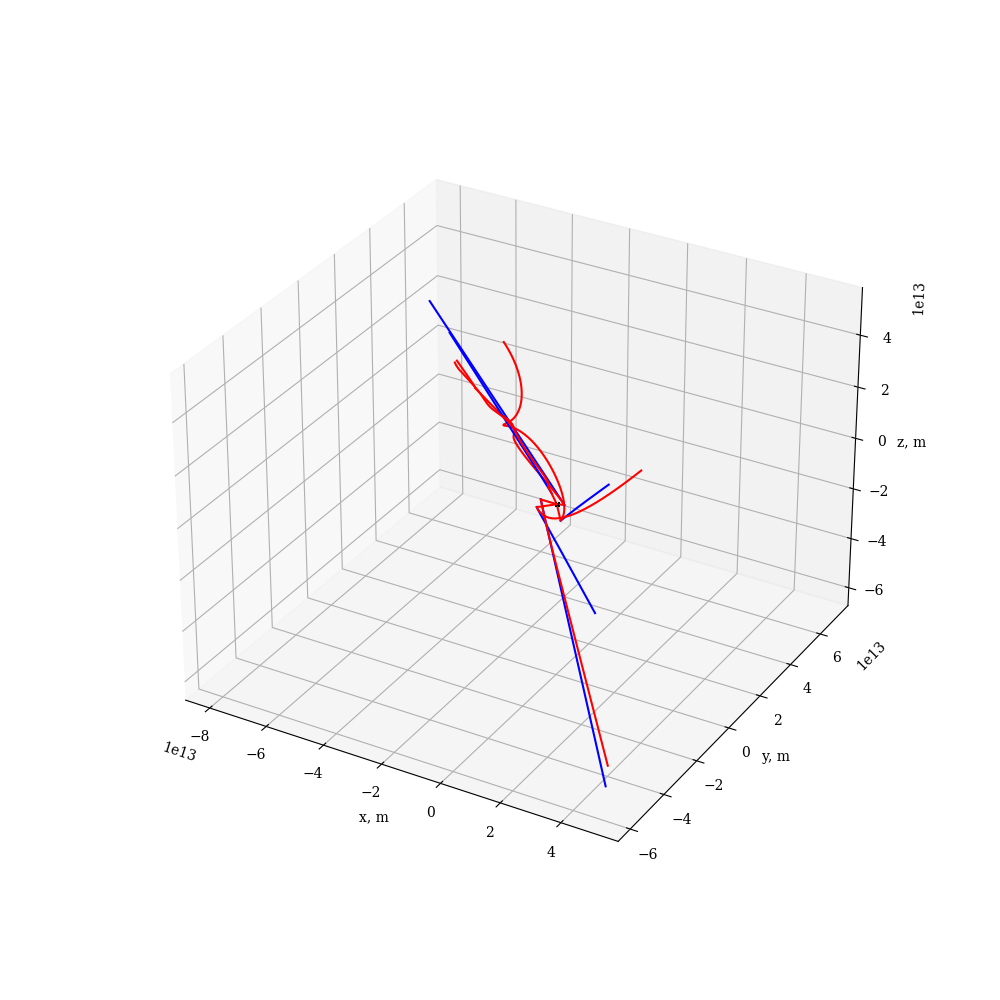

In [43]:
plt.figure(figsize=(10,10))
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

for i in range(5):
    plt.plot(x[i][0], y[i][0], z[i][0], "kx", markersize=3)
    plt.plot(clusterObjectList[i].xarr, clusterObjectList[i].yarr, clusterObjectList[i].zarr, "b")
    plt.plot(x[i], y[i], z[i], "r")


plt.xlabel("x, m")
plt.ylabel("y, m")
ax.set_zlabel("z, m")
